In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 26 11:55:40 2025

@author: mrsag
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import scipy.integrate as integrate
# from Curve_fitting_with_scipy import polynomial_fit as pft
import glob
from scipy.interpolate import interp1d

import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 17
#mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi']=100 # highres display


In [2]:
# Defining constants:
cm = 1e-2
mm = 1e-3
e = 1.6e-19
me = 9.11e-31
keV_to_Joule = 1.6e-16
c_light=3e8  # in SI unit


In [3]:
B_field = 0.45 # Magnetic Field (B)  (in Tesla)
lB = 5*cm  # Magnetic field length (lB)  (in cm)
DB = (32.3+1.75)*cm # Distance of screen from magnetic field region endpoint (DB)  (in cm)
qp = 1*e # Charge of proton in terms of proton charge (q)
mH = 1836*me # Mass of particle (in terms of electron mass)


In [4]:
def find_index(array, value):
    # Calculate the absolute differences between each element and the target value
    absolute_diff = np.abs(array - value)
    
    # Find the index of the minimum absolute difference
    index = np.argmin(absolute_diff)
    
    return index


def point_avg(arr,n):
    arr1=[]
    for i in range(int(len(arr)/n)):
        x=np.mean(arr[n*i:n*(i+1)])
        arr1.append(x)
    arr1.append(np.mean(arr[(int(len(arr)/n))*n:]))
    
    return(arr1)


def parabolic_curve(x, a, b, c):
    """Returns y values for a parabola y = ax^2 + bx + c."""
    return a * x**2 + b * x + c



In [5]:
@np.vectorize
def radius_of_curvature(energy,m=mH,q=qp,B=B_field):
    f1=(m*c_light)/(q*B)
    f2=np.sqrt((1+energy/(m*c_light**2))**2-1)
    R = f1*f2
    return R

@np.vectorize
def magnetic_shift(energy,DB=DB,lB=lB,m=mH,q=qp,B=B_field):
    R = radius_of_curvature(energy,m,q,B)
    l1 = R-np.sqrt(R**2-lB**2)
    l2 = lB*DB/np.sqrt(R**2-lB**2)
    L = l1+l2
    return L

@np.vectorize
def angular_dependence(energy,DB=DB,lB=lB,m=mH,q=qp,B=B_field):
    R = radius_of_curvature(energy,m,q,B)
    val = np.sqrt(R**2-lB**2)/R
    return val


For LB = 13.256 mm, E_proton = 18.255 MeV


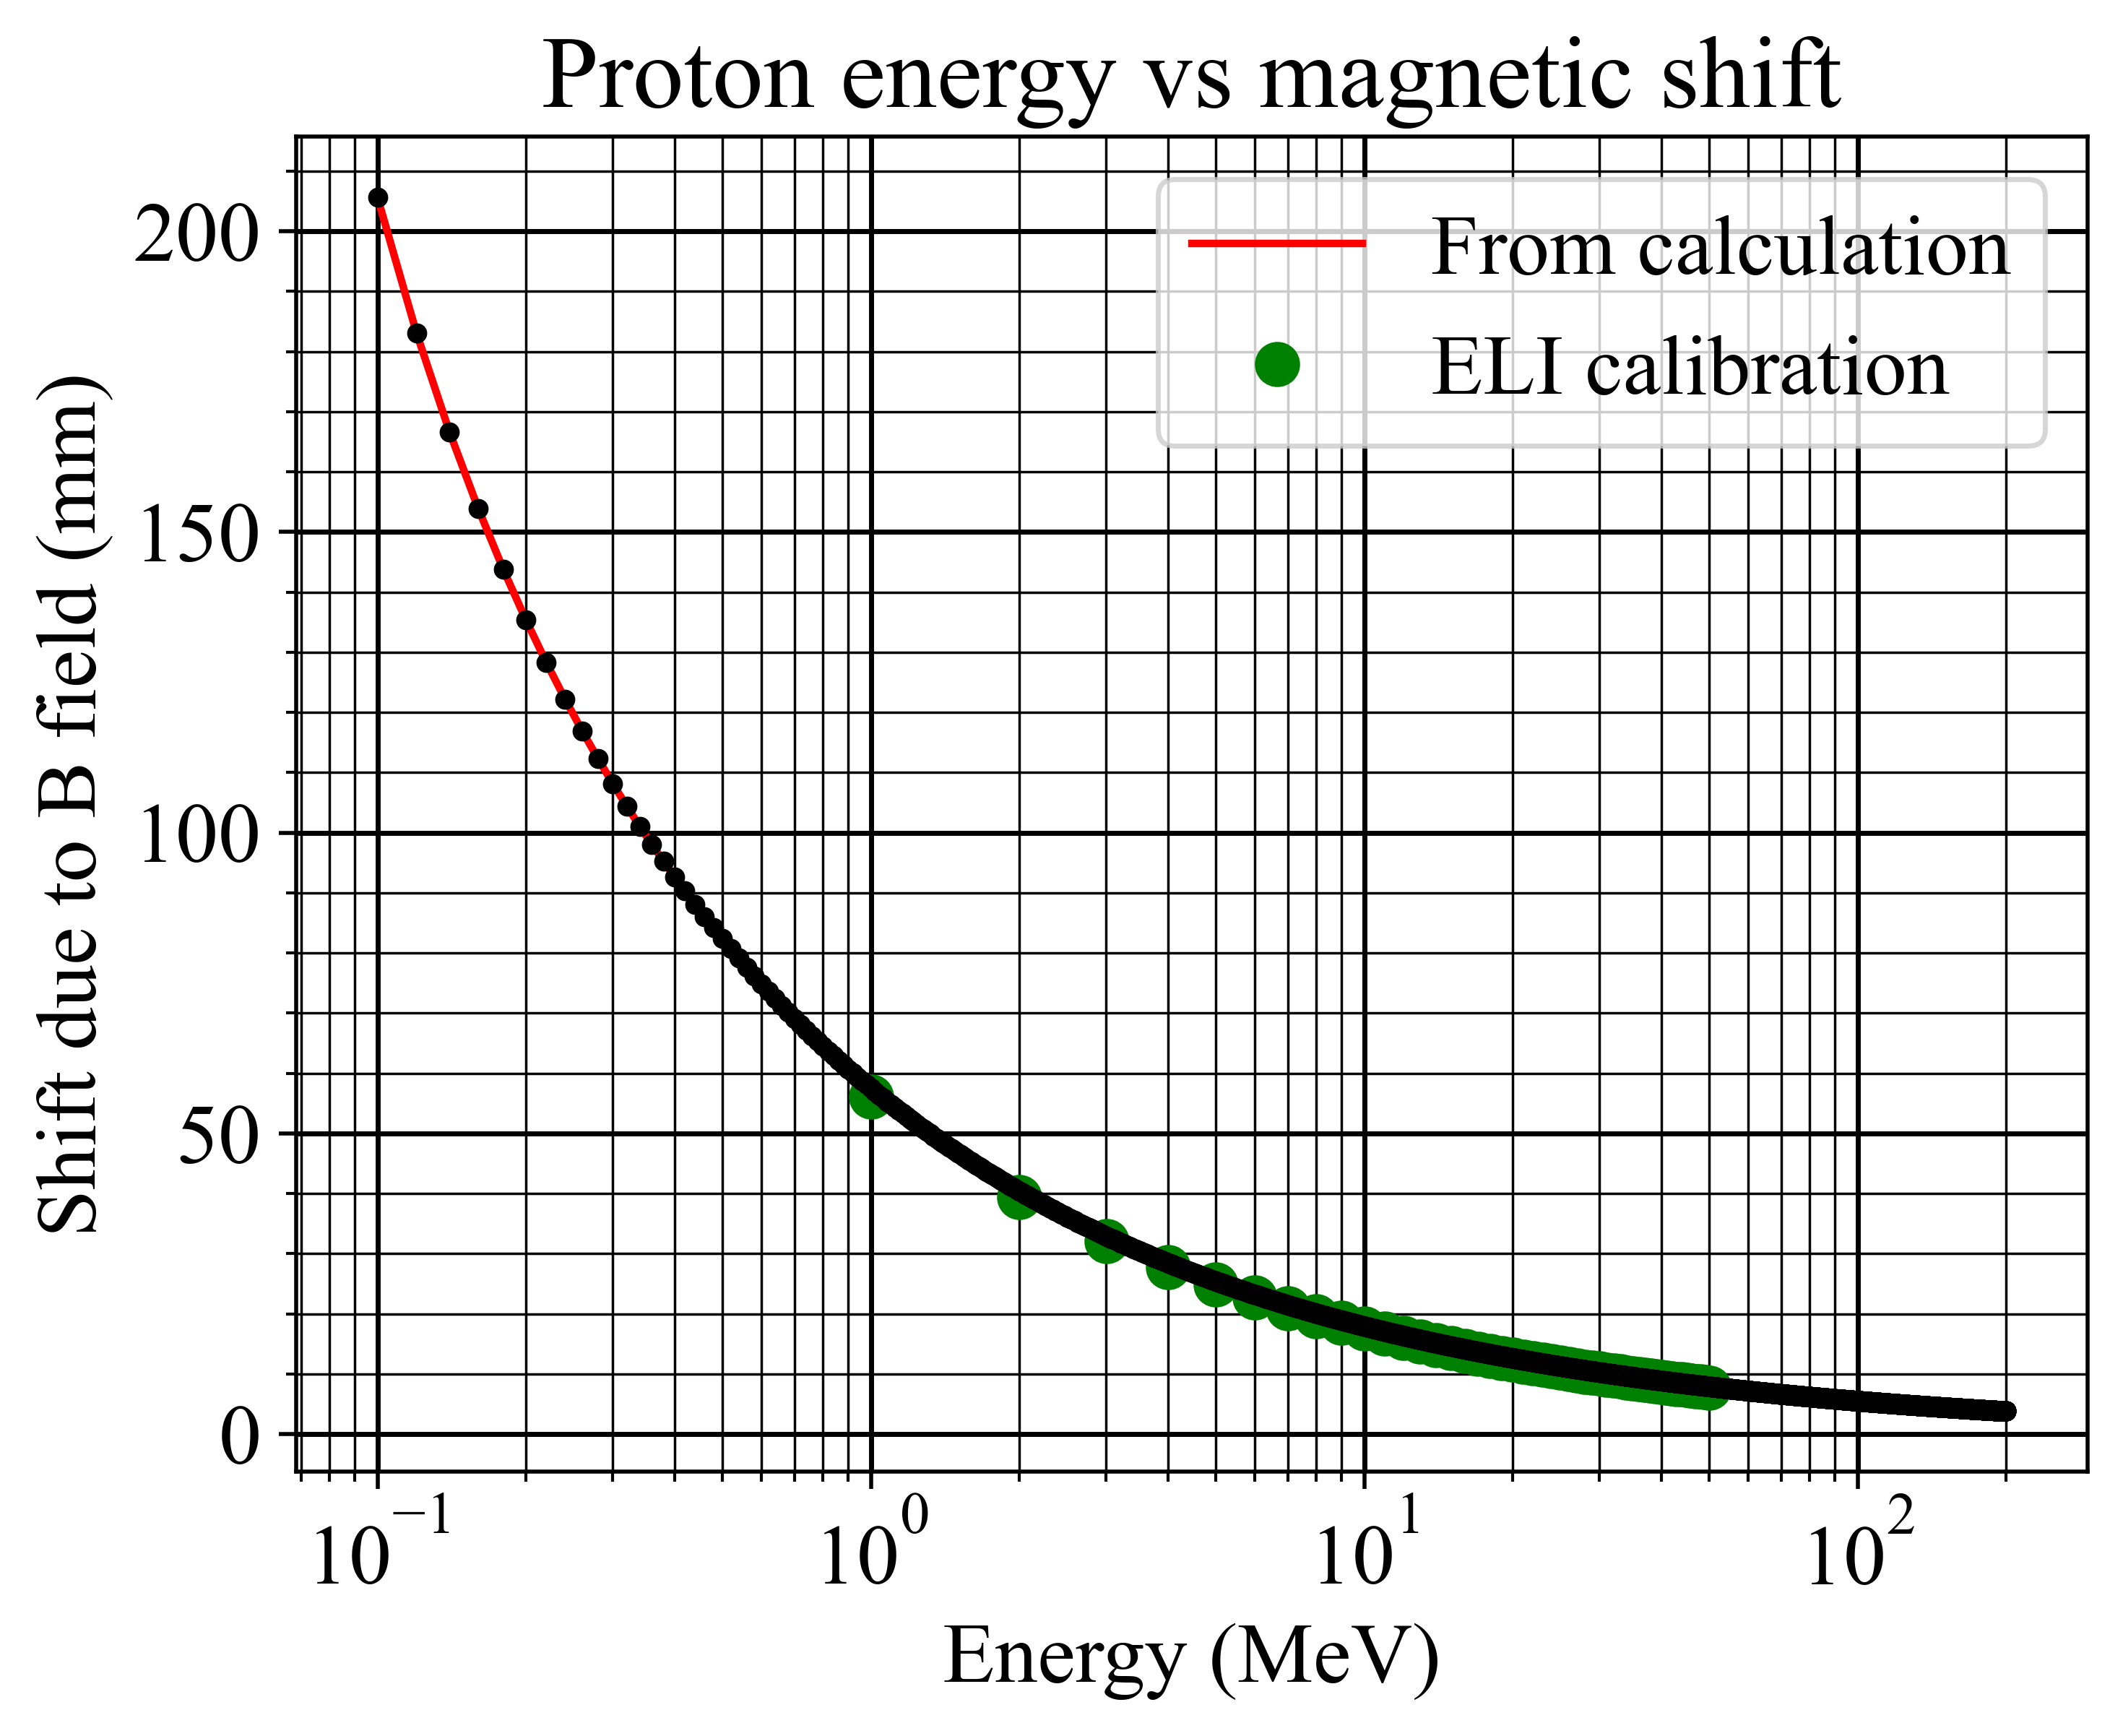

In [6]:
energy_chart = np.linspace(100,200000,10000)*keV_to_Joule
LB_chart = magnetic_shift(energy=energy_chart,DB=DB,lB=lB,m=mH,q=qp,B=B_field)

# Since LB is decreasing, reverse both arrays to make interpolation work
LB_to_E = interp1d(LB_chart[::-1], energy_chart[::-1], kind='cubic', fill_value='extrapolate')

given_LB = 13.256*mm  # energy in keV
E_result = LB_to_E(given_LB)/keV_to_Joule

print(f"For LB = {given_LB/mm} mm, E_proton = {E_result/1000 :.3f} MeV")

chart_file_path = r"D:\data Lab\ELI-NP March 2025\TP dimensions\Core1_045T_50mm.xlsx"
# Read the Excel file
df = pd.read_excel(chart_file_path)
df = np.array(df)
dist = df[2:,0]
energy_calib = df[2:,1]

# plt.figure(figsize=(2,1))
plt.plot(energy_chart/keV_to_Joule/1e3,LB_chart/mm,"r-",label="From calculation")
plt.plot(energy_calib,dist,"go",markersize=8,label="ELI calibration")
plt.plot(energy_chart/keV_to_Joule/1e3,LB_chart/mm,"ko",markersize=3)
plt.xlabel("Energy (MeV)")
plt.ylabel("Shift due to B field (mm)")
plt.xscale("log")
# plt.yscale("log")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=1, color='k')
plt.grid(which='minor', linestyle='-', linewidth=0.5, color='k')
plt.title("Proton energy vs magnetic shift")
plt.legend()
plt.show()


In [7]:
imagepath = r"D:\data Lab\ELI-NP March 2025\10_04_2025\separated_TP_images\10042025_TP_20_13_SCAN1-[Phosphor]_shot4.tif"
image = io.imread(imagepath)
a = 17
b = image.shape[0]
c = 0
d = 626
image2 = image[a:b,c:d]
image = image[a:b,:]
description = r"Au Nano wires 350nm sub 200nm diameter gap 250nm height 1$\mu$m"

# image = np.flip(image, axis=1)
# image = np.flip(image, axis=0)
image = np.flipud(image.T)
image2 = np.flipud(image2.T)
log_image_cutoff = 7

noise = np.mean(image[288:488,324:456])
pixel_to_mm = 0.025


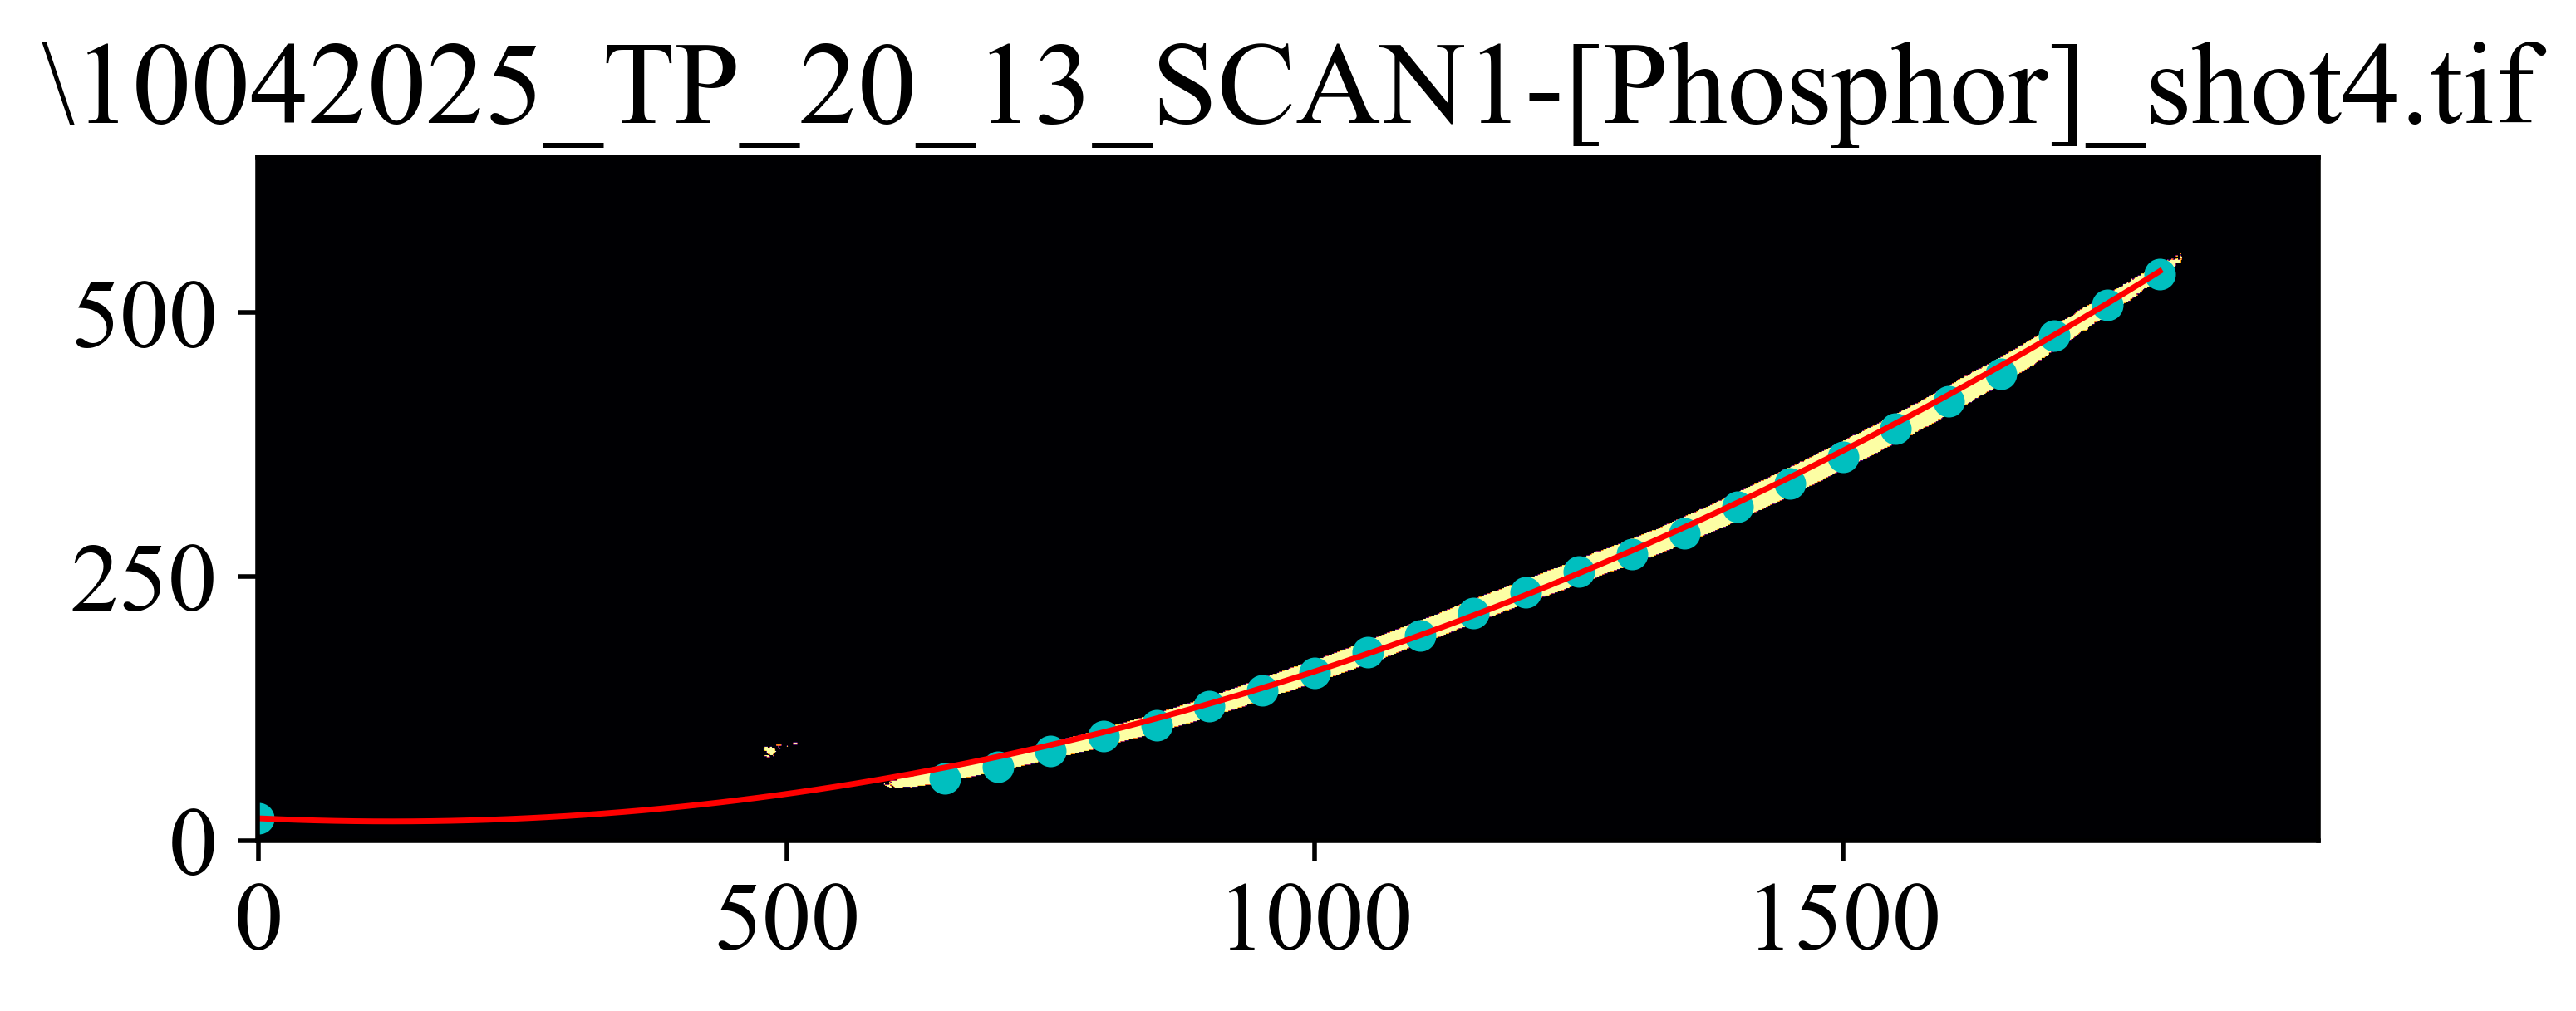

In [8]:
points = [[0, 0]]

for i in range(650,1850,50):
    max_x_index = find_index(image2[:,i],np.max(image2[:,i]))
    x0,y0 = max_x_index, i
    points.append([x0,y0])
    
# points.append([image.shape[0]-(276-c), 2058-a])

points = np.array(points)
# Fit a parabola (y = ax^2 + bx + c)
x = points[:, 1]
y = points[:, 0]
coeffs = np.polyfit(x, y, 2)  # Quadratic fit
coeffs[2] = 0

offset = -1
coeffs[2] += ((image.shape[0]-d)+offset)

y += ((image.shape[0]-d)+offset)
x_vals = np.linspace(min(x), max(x), 100)
y_vals = np.polyval(coeffs, x_vals)

plt.imshow(np.log(image)>log_image_cutoff,cmap="inferno",origin="lower")# ,extent=[x_min, x_max, y_min, y_max])
plt.plot(x_vals, y_vals, color='red', linewidth=1)  # Draw parabola
plt.scatter(x, y, color='c', s=20)  # Mark given points
plt.title(imagepath[-45:])
plt.show()


In [9]:
def extract_linecut(image, a, b, c, x_range=None, band=0, num_points=1000,logimage=False,log_image_cutoff=7, plot_logscale=False):
    """Extracts pixel intensity values along a parabolic curve."""
    
    h, w = image.shape
    
    imagelog = (np.log(image))
    imagelog = imagelog>log_image_cutoff

    # Define x range
    if x_range is None:
        x_range = (0, w-1)

    # Generate x values
    x_values = np.linspace(x_range[0], x_range[1], num_points).astype(int)
    y_values = parabolic_curve(x_values, a, b, c).astype(int)
    valid_idx = (y_values >= 0) & (y_values < h)
    length = len(y_values[valid_idx])
    x_values = x_values[valid_idx]
    
    intensities = np.zeros(length)

    for val in range(-band,band+1):
        y_values = parabolic_curve(x_values, a, b, c-val).astype(int)
        

        # Filter valid points
        valid_idx = (y_values >= 0) & (y_values < h)
        for j in range(len(valid_idx)):
            if(valid_idx[j]==False):
                y_values[j]=parabolic_curve(x_values, a, b, c).astype(int)[j]
        
        # Filter valid points
        valid_idx = (y_values >= 0) & (y_values < h)
        x_values, y_values = x_values[valid_idx], y_values[valid_idx]
    
        intensities += image[y_values, x_values]/(2*band+1)
    
    # print(len(intensities))

    # Plot the results
    fig, axes = plt.subplots(2, 1, figsize=(10,10))
    
    # Show original image with curve
    axes[0].imshow(imagelog, cmap="inferno",origin="lower")
    axes[0].plot(x_values, parabolic_curve(x_values, a, b, c).astype(int), 'r-', linewidth=band)
    axes[0].plot(x_values[::50], (parabolic_curve(x_values, a, b, c).astype(int))[::50], 'bo', linewidth=0)
    axes[0].set_title(f"{imagepath[-45:-4]}"+"\nParabolic Linecut on Image"+"\n"+description)
    axes[0].set_xlabel("x axis"+"\n=================================================================================")


    # Plot intensity profile
    axes[1].plot(x_values, intensities, 'b-', lw=1)
    axes[1].plot(point_avg(x_values,20),point_avg(intensities,20),"k-",lw=2)
    # axes[1].axhline(y=noise+max(intensities)/1e2, color='r', linestyle='--', lw=2)
    minval = 50
    maxval = 335
    axes[1].axhline(y=1.5*np.mean(intensities[find_index(x_values,minval):find_index(x_values,maxval)]), color='r', linestyle='--', lw=2)
    axes[1].plot([x_values[find_index(x_values,minval)],x_values[find_index(x_values,maxval)]],[intensities[find_index(x_values,minval)],intensities[find_index(x_values,maxval)]],'go',markersize=3)

    tp_cut_pixel = (point_avg(x_values,20))[find_index(point_avg(intensities,20)[0:40], 1.5*np.mean(intensities[find_index(x_values,minval):find_index(x_values,maxval)]))]
    # tp_cut_pixel = 413 
    
    
    cutoff_length = tp_cut_pixel*pixel_to_mm
    chart_file_path = r"D:\data Lab\ELI-NP March 2025\TP dimensions\Core1_045T_50mm.xlsx"
    # Read the Excel file
    df = pd.read_excel(chart_file_path)
    df = np.array(df)
    dist = df[2:,0]
    energy_calib = df[2:,1]
    tp_cutoff_energy = energy_calib[find_index(dist,cutoff_length)]

    print(f"Cutoff length = {cutoff_length:.2f} mm")
    print(f"cutoff energy = {tp_cutoff_energy: .2f} MeV")
    axes[1].axvline(x = tp_cut_pixel,color='r', linestyle='--', lw=2)
    axes[0].axvline(x = tp_cut_pixel,color='r', linestyle='--', lw=2)
    
    if(plot_logscale):
        axes[1].set_yscale("log")
    
    axes[1].set_title("Intensity Profile Along Curve")
    axes[1].set_xlabel(r"Pixel Index Along $\vec v\times \vec B$ (x axis of parabola)"+f"\nCutoff Pixel: {tp_cut_pixel}; Cutoff length = {tp_cut_pixel*pixel_to_mm:.2f} mm; Cutoff energy: {tp_cutoff_energy:.2f} MeV")
    axes[1].set_ylabel("Intensity")
    axes[1].set_ylim(min(intensities)/1.1,max(intensities)*1.1)
    axes[1].set_xlim(0,image.shape[1])
    axes[1].grid(which="both", lw=0.5, color="k")
    plt.show()


def get_magnetic_trace(image,coeffs,x_range=None, band=5):
    h, w = image.shape
    extract_linecut(image, a=coeffs[0], b=coeffs[1], c=coeffs[2], band=3, num_points=image.shape[1],logimage = False, log_image_cutoff=log_image_cutoff,plot_logscale=1)  # Example parabola

    x_values = np.arange(0,w-50,1)
    y_values = np.polyval(coeffs, x_values).astype(int)
    valid_idx = (y_values >= band) & (y_values < h-band)
    x_values = x_values[valid_idx]
    y_values = y_values[valid_idx]

    mag_trace = np.zeros(shape=(2*band+1,len(x_values)))
    for i in range(len(x_values)):
        mag_trace[:,i] = image[y_values[i]-band:y_values[i]+band+1,i]

    plt.imshow(np.log(image)>7,cmap="inferno",origin="lower") # ,extent=[x_min, x_max, y_min, y_max])
    # plt.plot(x_values, y_values, color='red', linewidth=1)  # Draw parabola
    plt.fill_between(x=x_values,y1=y_values-band,y2=y_values+band,color="r",alpha=0.4)
    plt.axis("off")
    plt.title("selected band for proton trace")
    plt.show()

    return mag_trace


Cutoff length = 9.74 mm
cutoff energy =  32.00 MeV


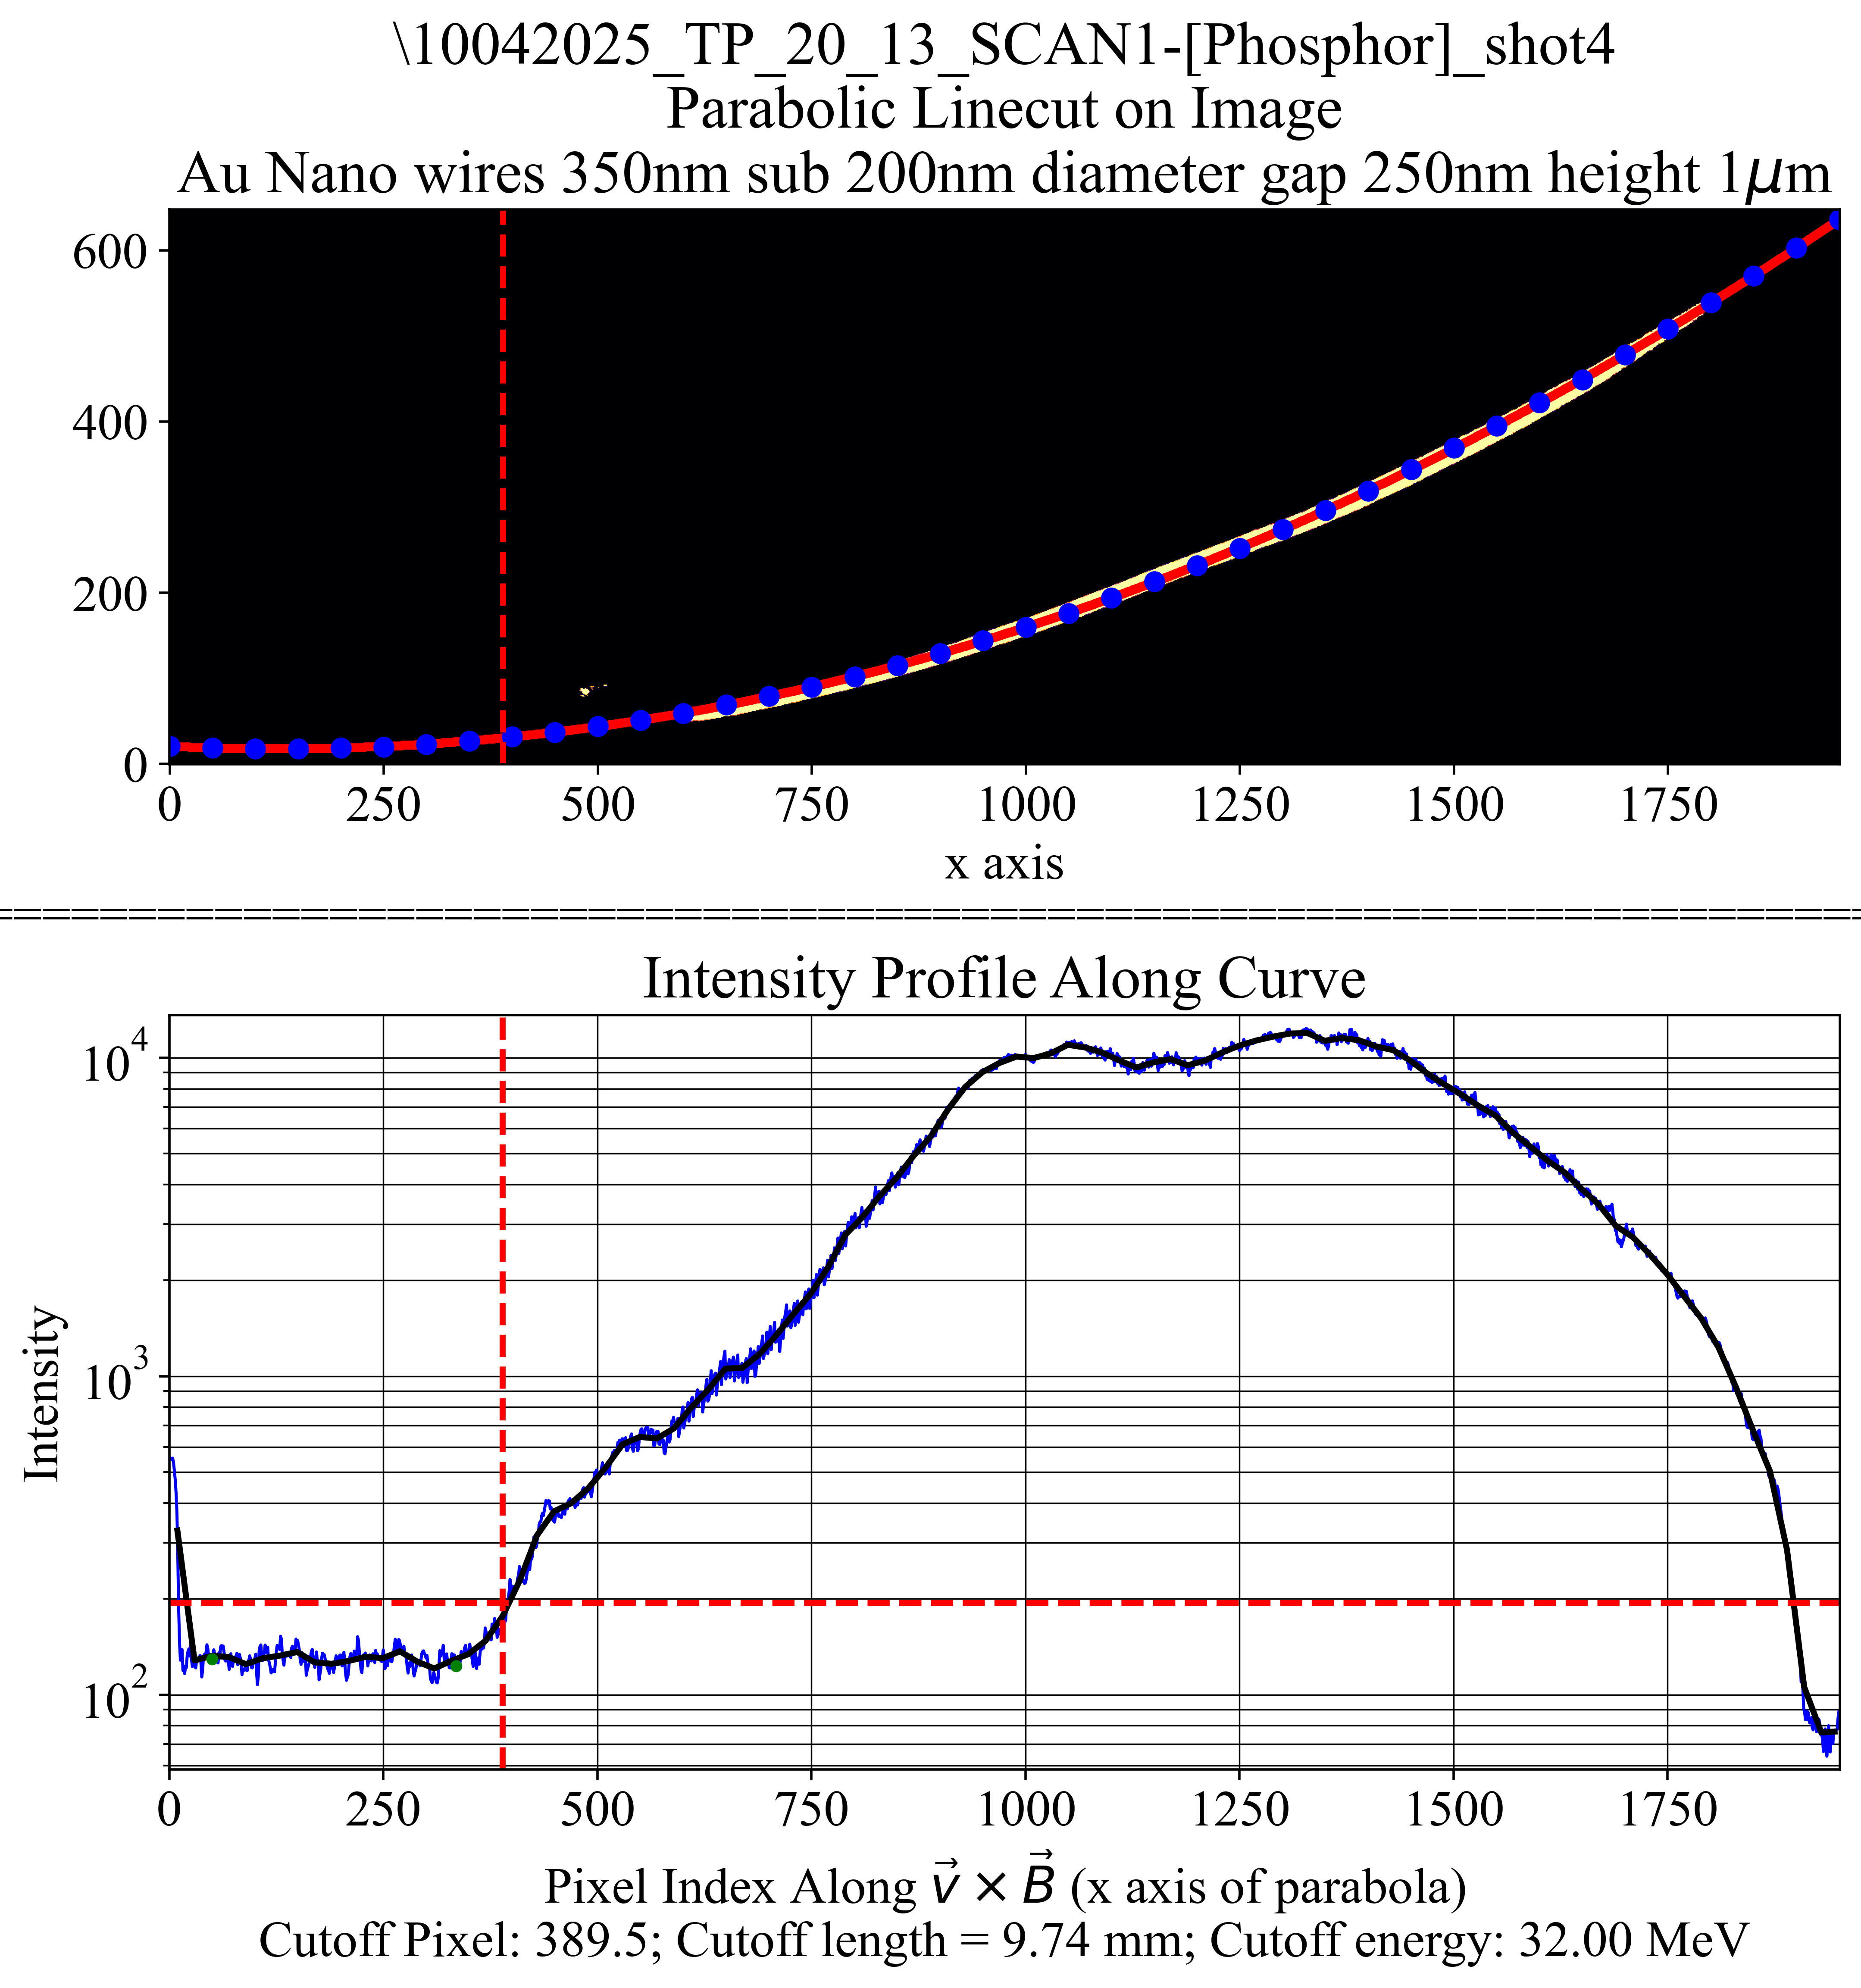

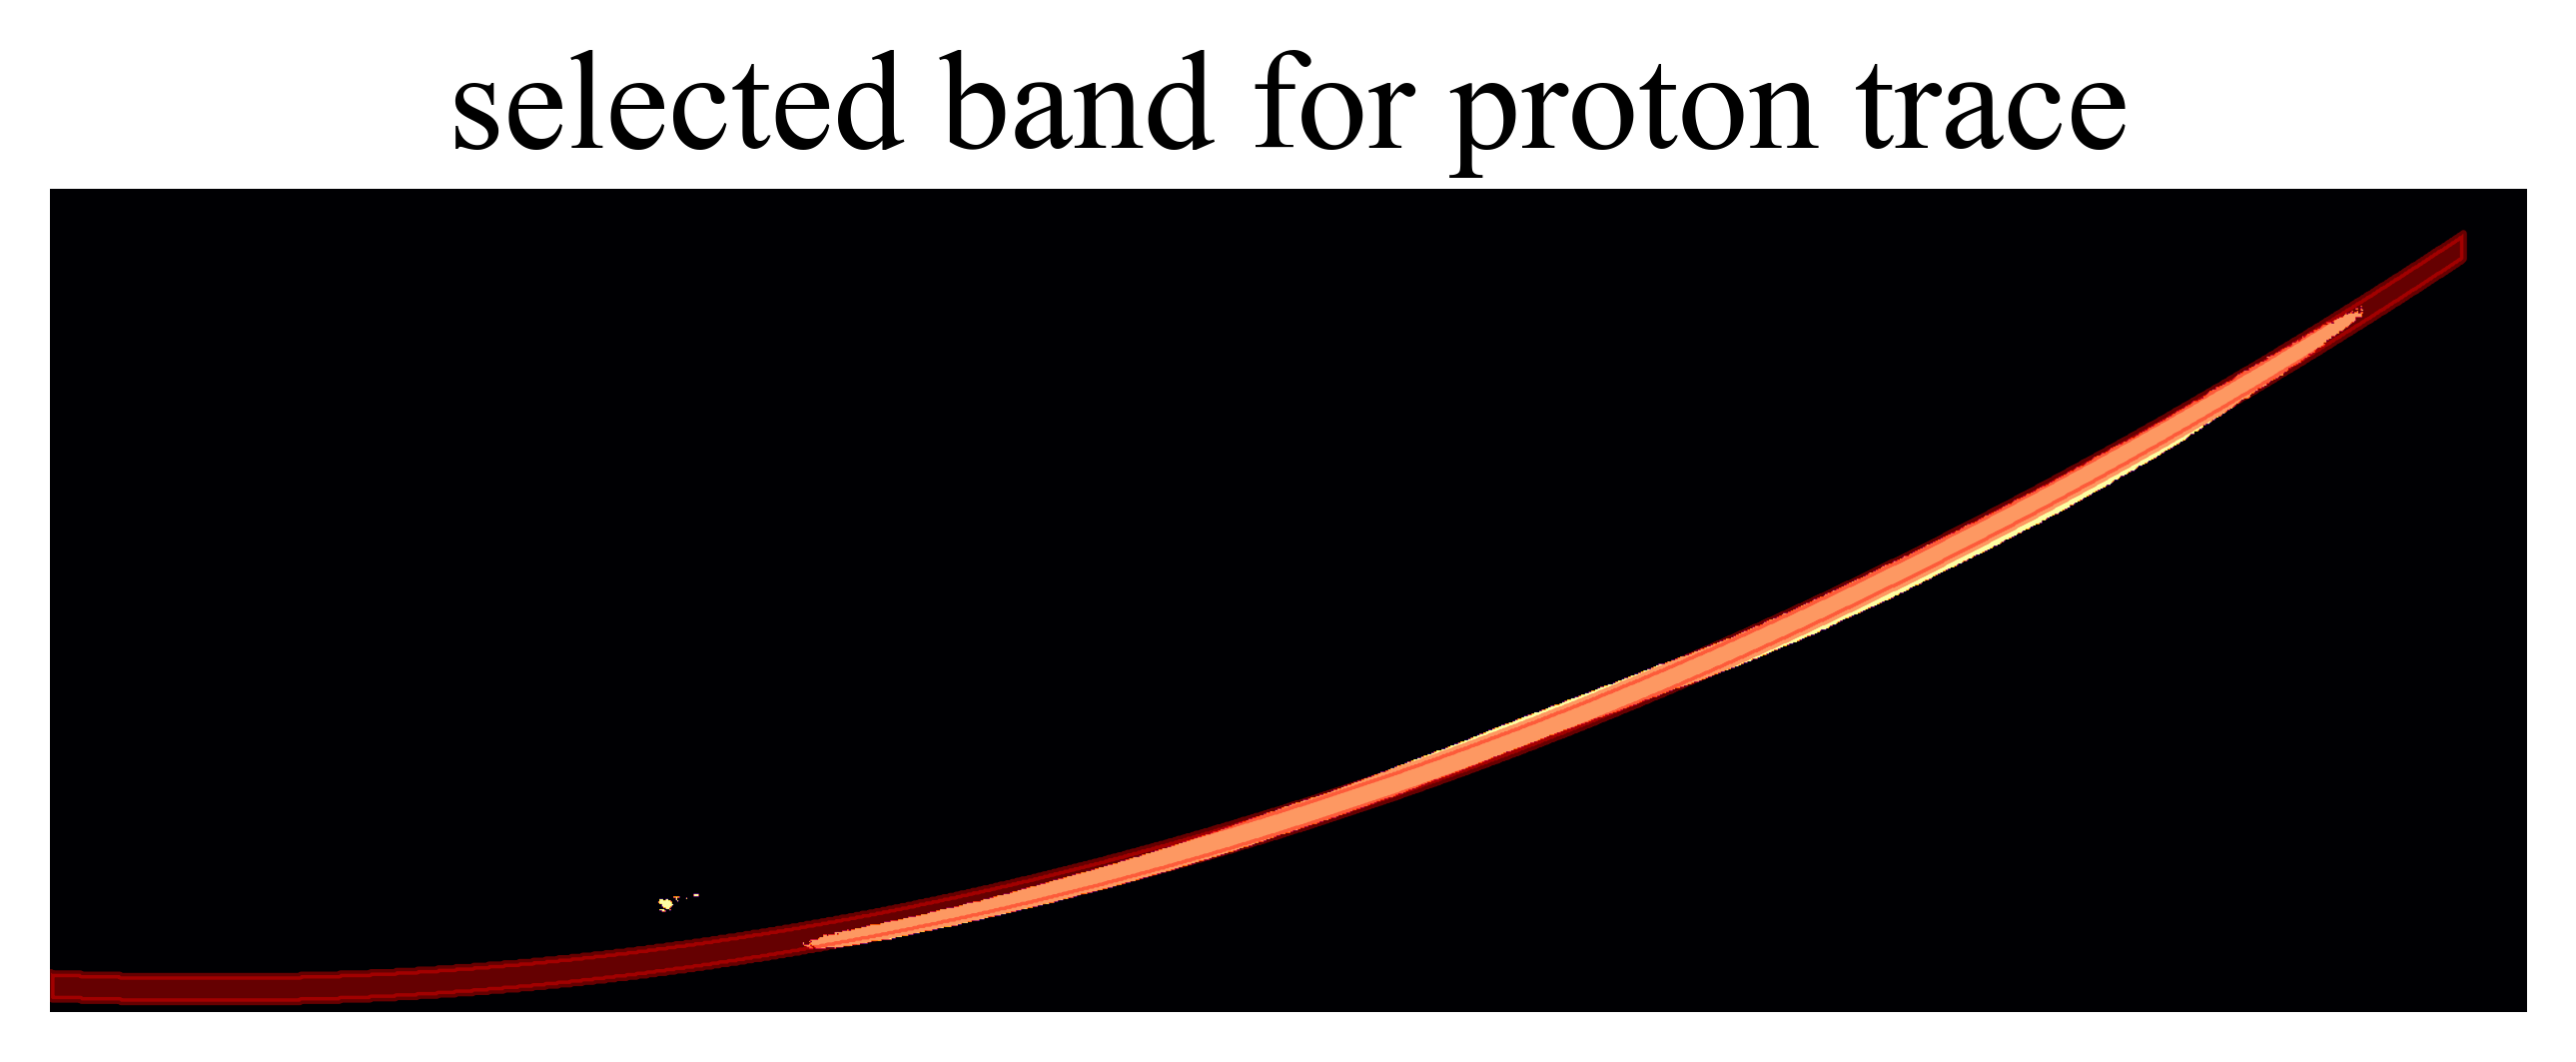

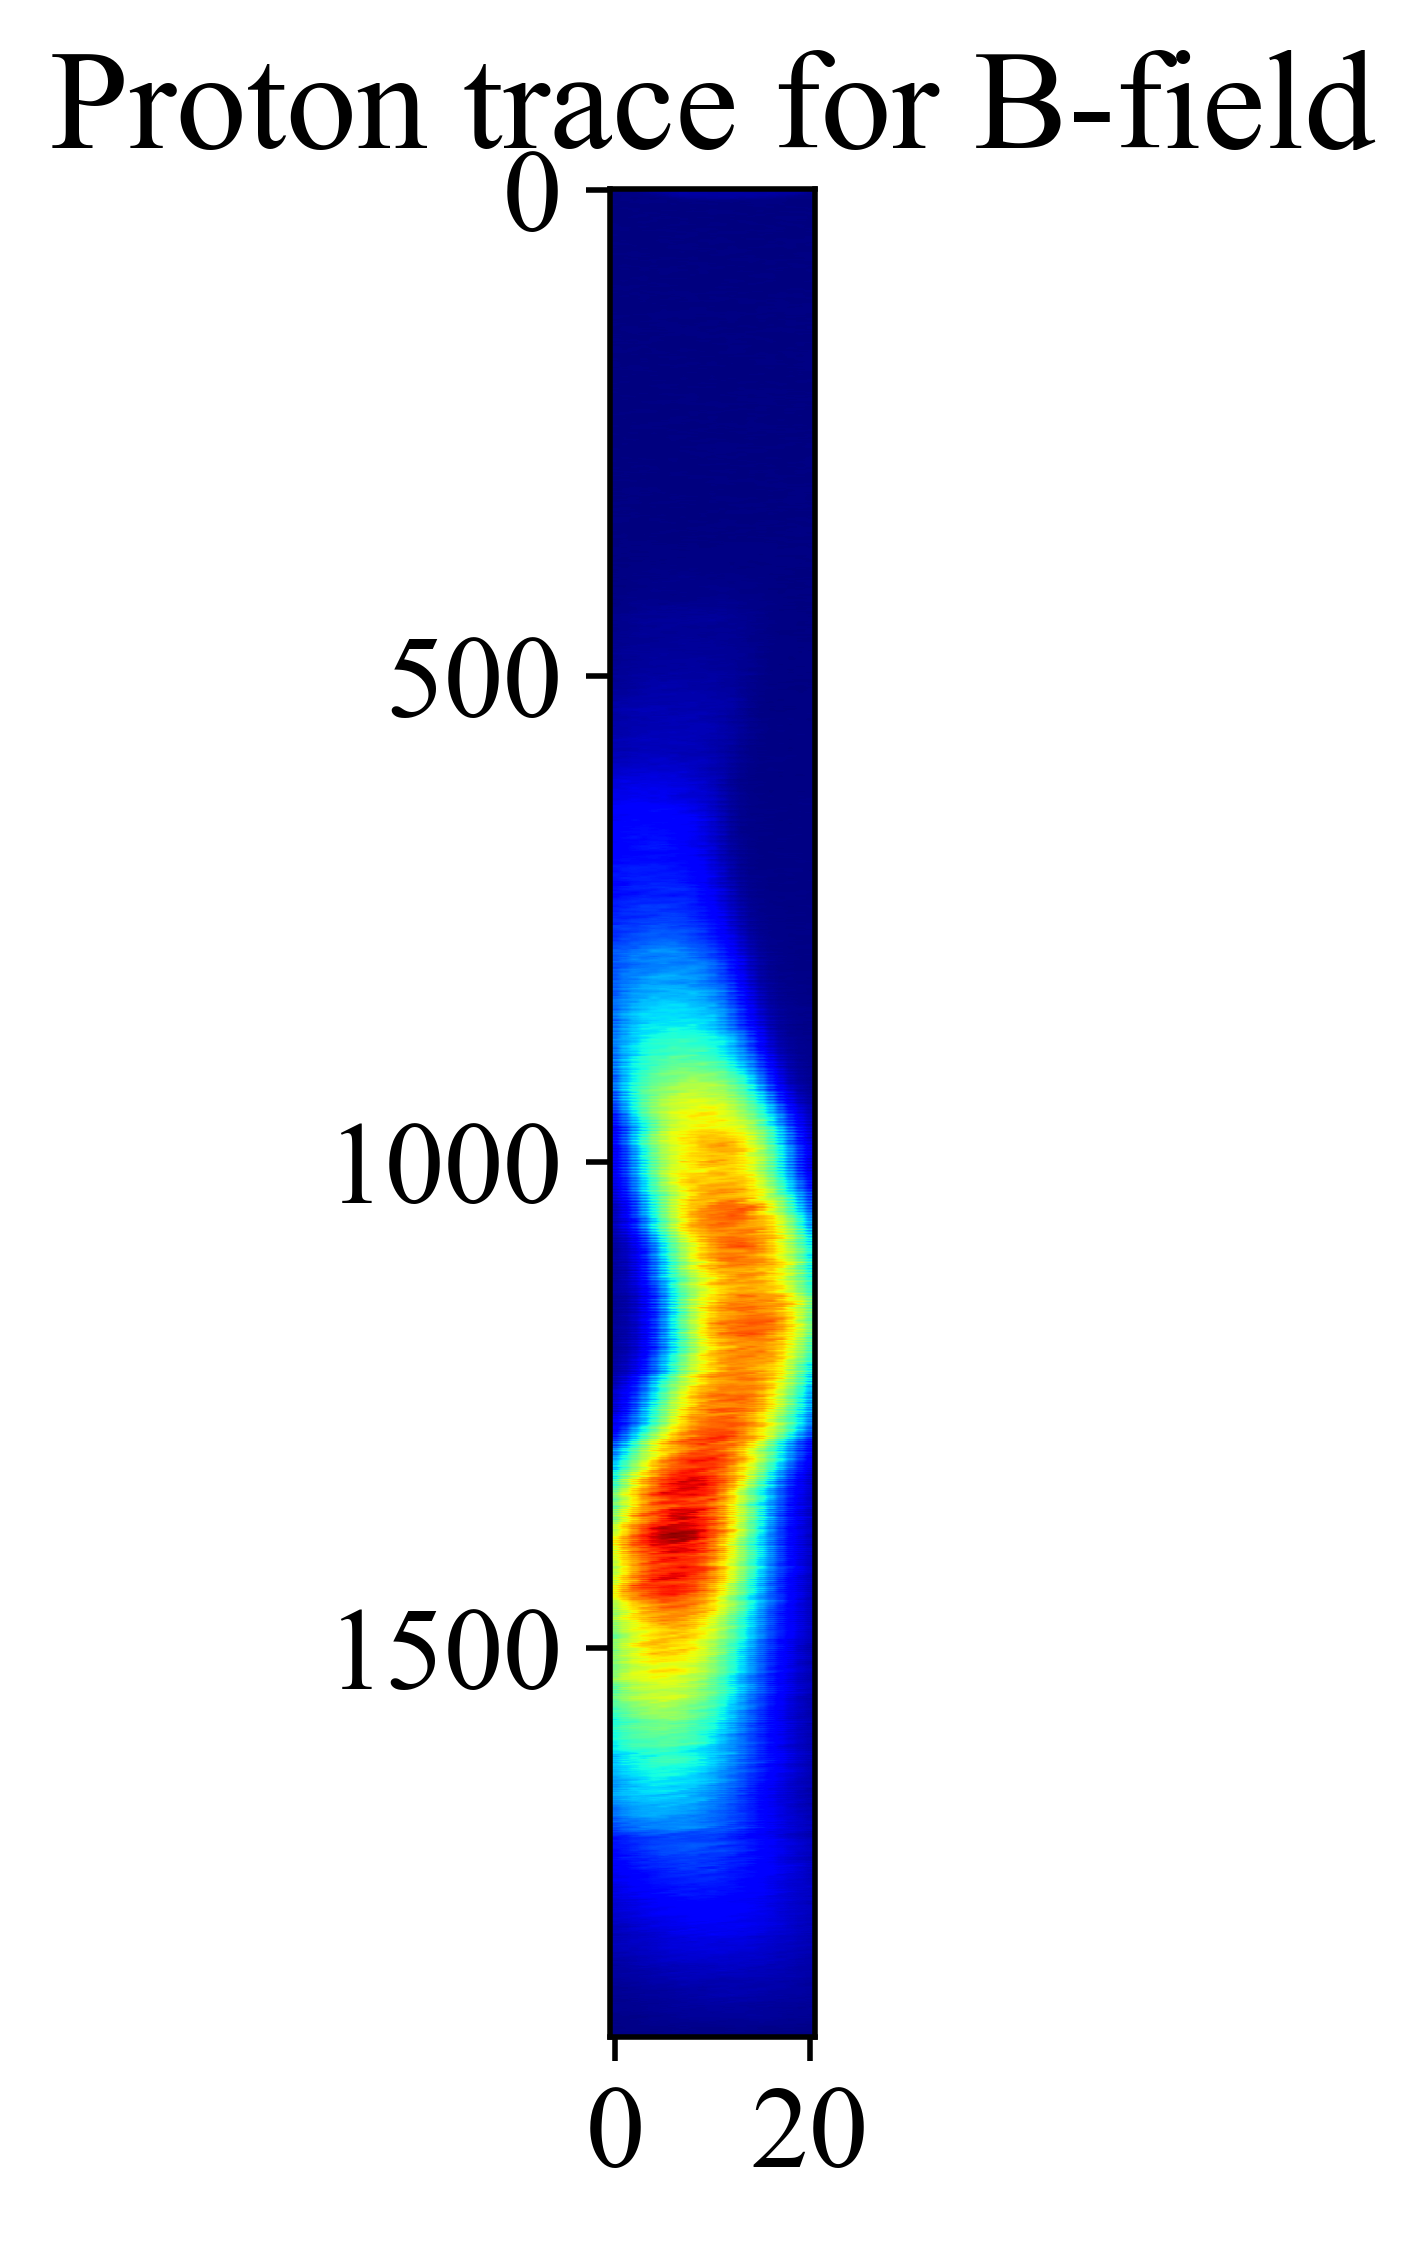

In [10]:
trace = get_magnetic_trace(image,coeffs,x_range=None,band=10)
trace = trace.T


plt.imshow(trace,cmap="jet",aspect=0.1)
plt.title("Proton trace for B-field")
# plt.axis("off")
plt.show()


In [11]:
def sensitivity(energy):
    E = energy/keV_to_Joule/1000
    if(E<1.6):
        PSL = 0.151*E**0.6
    if(E>=1.6):
        PSL = 0.284*E**(-0.75)
    return PSL


In [12]:
LB = np.arange(0,trace.shape[0])*pixel_to_mm*mm
Energy = LB_to_E(LB)

# Create Gaussian weights centered in the array
def gaussian_weights(length, sigma=2):
    x = np.linspace(-length // 2, length // 2, length)
    weights = np.exp(-x**2 / (2 * sigma**2))
    weights /= weights.sum()  # Normalize to sum to 1
    return weights


counts = []
for i in range(trace.shape[0]):
    signal = trace[i]
    weights = gaussian_weights(len(signal), sigma=3)
    s = np.sum(signal * weights)
    PSL = sensitivity(Energy[i]) * angular_dependence(energy=Energy[i])

    if(i>=200):
        count = s*PSL
    else:
        count = 0
    counts.append(count)
counts = np.array(counts)

def integrated_counts(Energy,counts):
    arr = []
    for E in Energy:
        true_index = (Energy<=E)
        arr.append(np.sum(counts[true_index]))
    return np.array(arr)

integrated_count = integrated_counts(Energy,counts)
cutoff_index_integrated_count = find_index(integrated_count,np.max(integrated_count)*0.9995)
cutoff_energy_from_spectrum = Energy[cutoff_index_integrated_count]


In [13]:

trace_cut = trace.T
L_low = round((LB_chart[find_index(energy_chart,200000*keV_to_Joule)]/mm)/pixel_to_mm)
L_high = round((LB_chart[find_index(energy_chart,np.min(Energy))]/mm)/pixel_to_mm)

trace_cut = np.flip(trace_cut[:,L_low:L_high],axis=1)


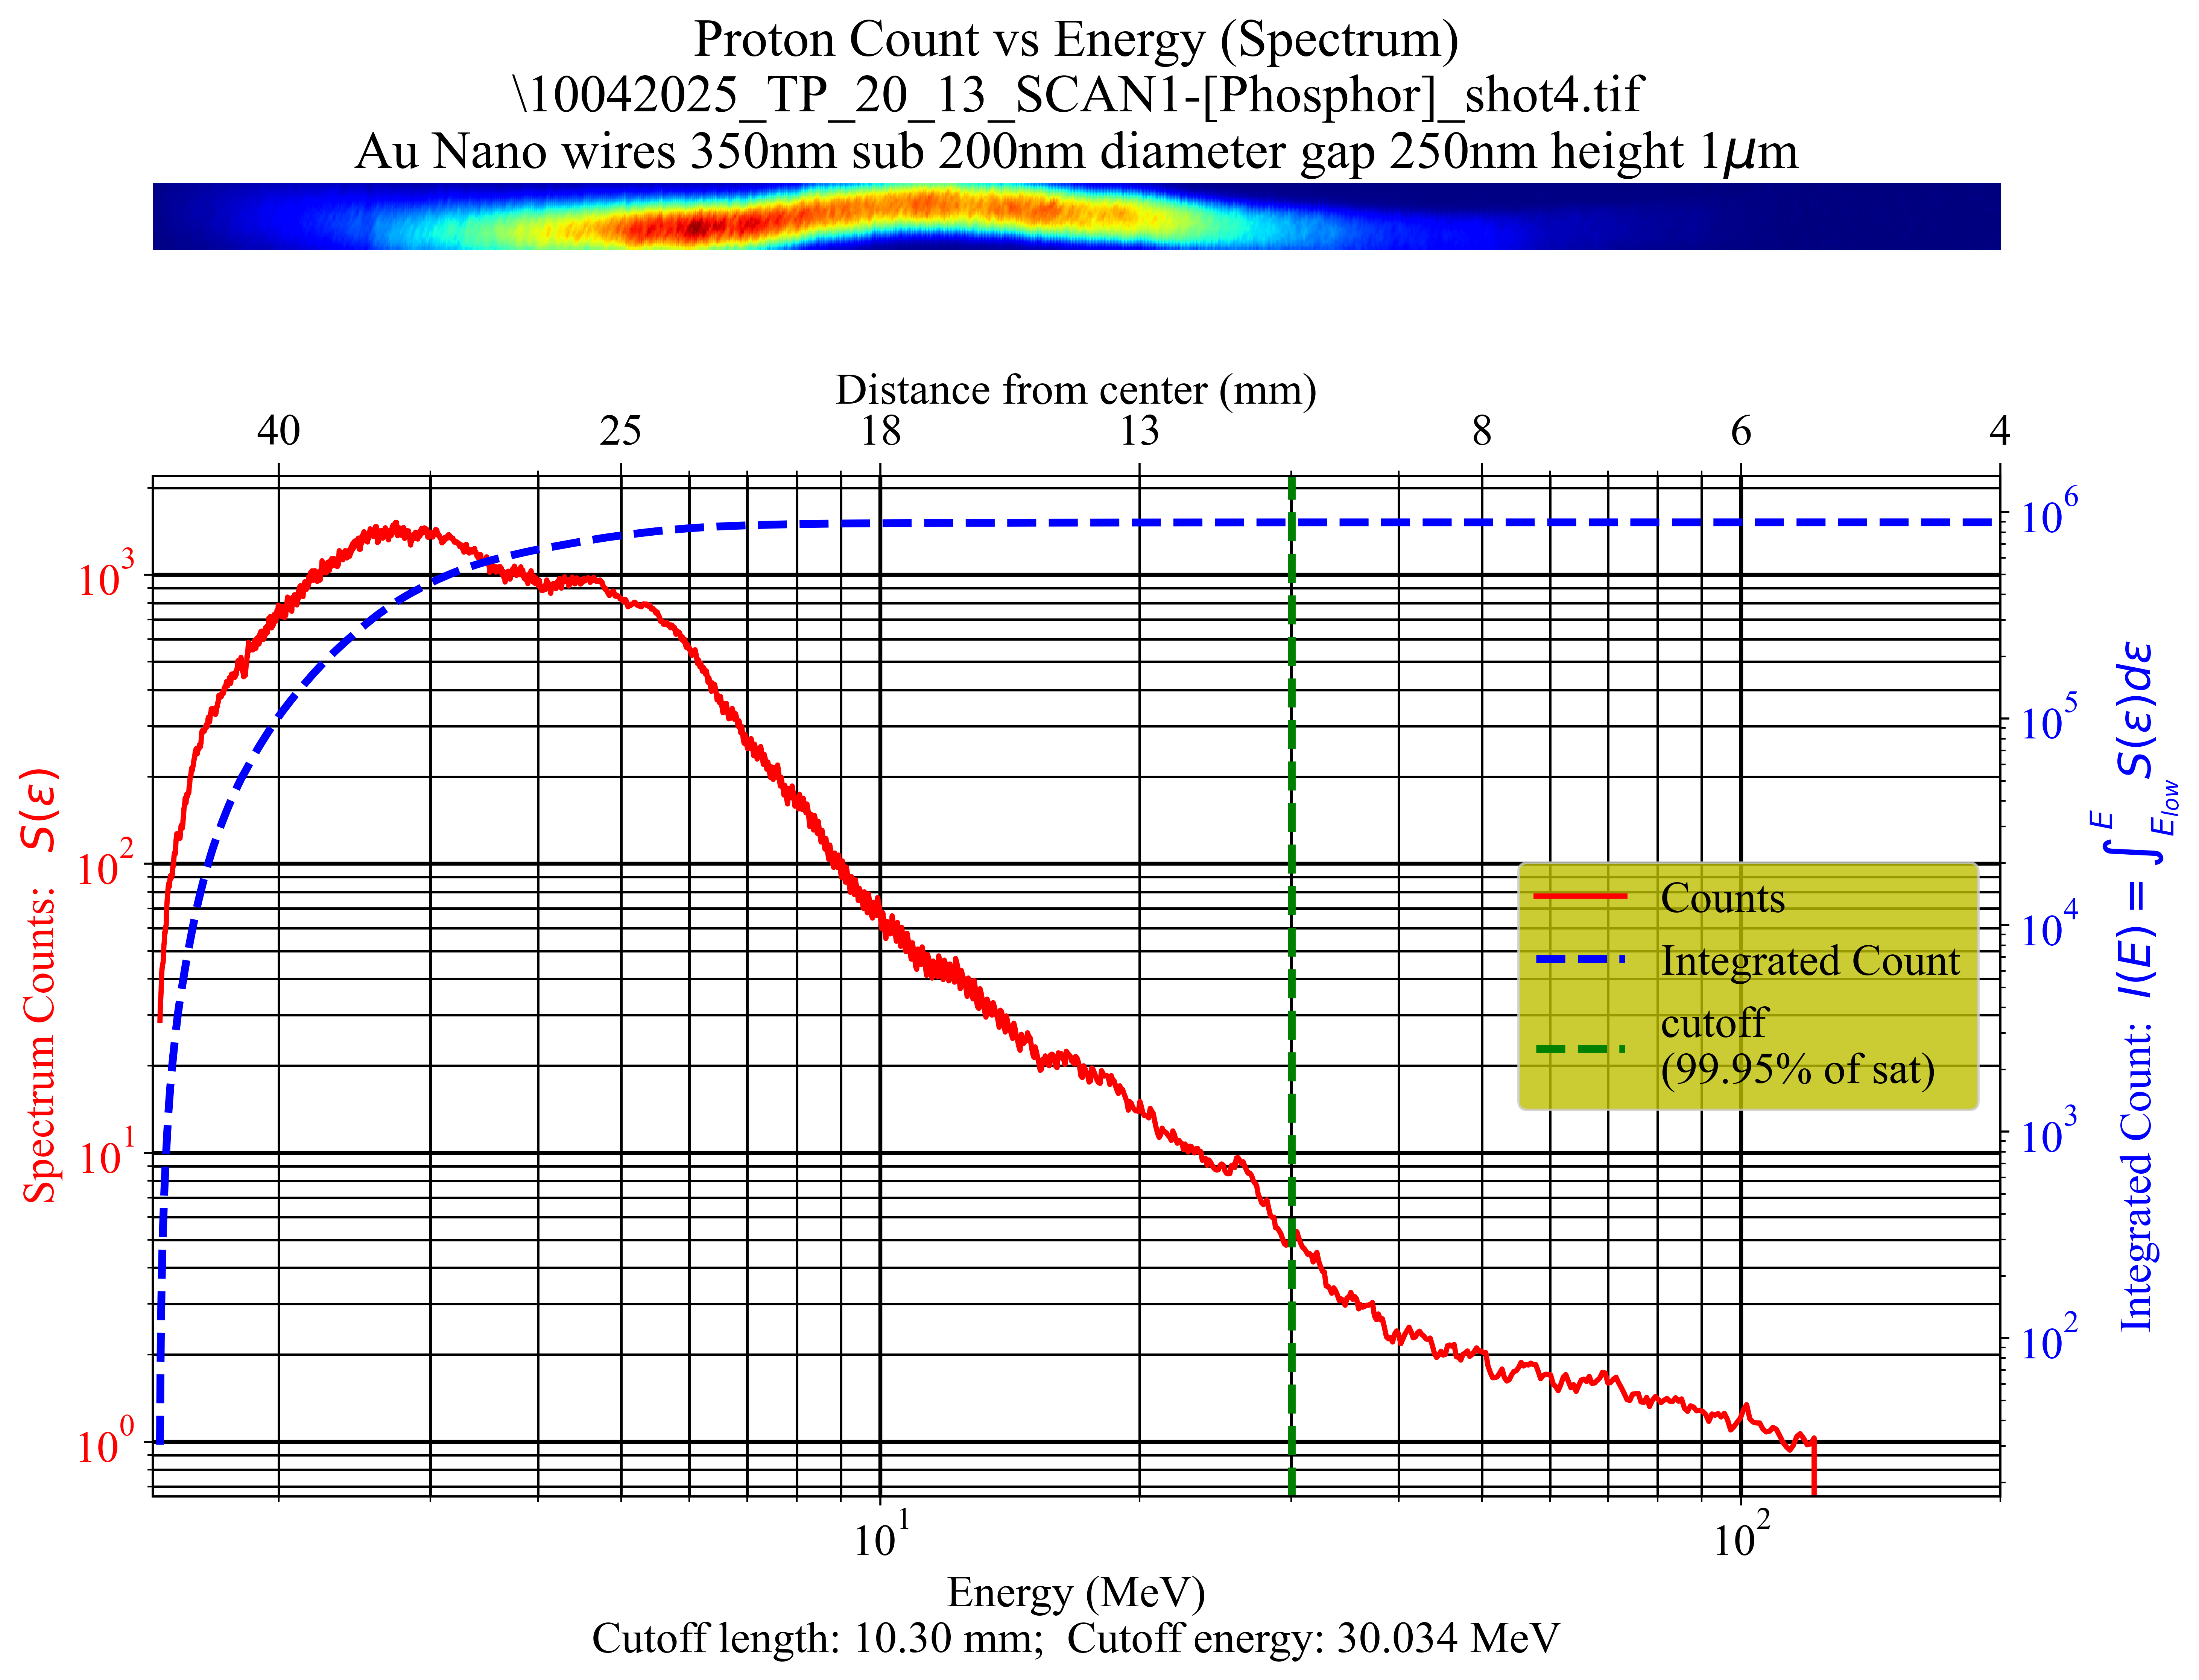

In [14]:

fig, (ax_top, ax1) = plt.subplots(nrows=2, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 3]})


# --- Top subplot: horizontal image ---
ax_top.imshow(trace_cut, cmap="jet", aspect=3, origin='lower')
ax_top.axis("off")
ax_top.set_title("Proton Count vs Energy (Spectrum)" + "\n" + imagepath[-45:] + "\n" + description)
# ax_top.set_xlim(0, 1000)  # optional, or adjust as needed

# --- Bottom subplot (your original plot) ---
p1, = ax1.plot(Energy / keV_to_Joule / 1000, counts, "r-", lw=2, label="Counts")
cutoff_MeV = cutoff_energy_from_spectrum / keV_to_Joule / 1000
p11 = ax1.axvline(x=cutoff_MeV, lw=3, linestyle="--", color="g", label="cutoff\n(99.95% of sat)")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Energy (MeV)\n" + f"Cutoff length: {magnetic_shift(cutoff_energy_from_spectrum)/mm:.2f} mm;  Cutoff energy: {cutoff_MeV:.3f} MeV")
ax1.set_ylabel(r"Spectrum Counts:   $S(\epsilon)$", color="r")
ax1.tick_params(axis='y', labelcolor='r')
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth=1.5, color='k')
ax1.grid(which='minor', linestyle='-', linewidth=1, color='k')
ax1.set_xlim(np.min(Energy)/ keV_to_Joule / 1000/1.02, 200)

# Twin y-axis
ax2 = ax1.twinx()
p2, = ax2.plot(Energy / keV_to_Joule / 1000, integrated_count, "b--", lw=3, label="Integrated Count")
ax2.set_yscale("log")
ax2.set_ylabel("Integrated Count:  "+r"$I(E)=\int_{E_{low}}^ES(\epsilon)d\epsilon$", color="b")
ax2.tick_params(axis='y', labelcolor='b')

# Legend
lines = [p1, p2, p11]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right', facecolor='y')


energy_tick_positions = np.array([2,5,10,20,50,100,200])
distance_labels = (np.round(magnetic_shift(energy_tick_positions*1e3*keV_to_Joule)/mm)).astype(int)

secax = ax1.secondary_xaxis('top')
secax.set_xticks(energy_tick_positions)
secax.set_xticklabels(distance_labels)
secax.set_xlabel("Distance from center (mm)")
secax.tick_params(axis='x', direction='out', length=5)

# plt.title("Proton Count vs Energy (Spectrum)" + "\n" + imagepath[-45:] + "\n" + r"Flat 2$\mu$m")
plt.tight_layout()
plt.show()
